In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import ipywidgets as widgets

import statsmodels
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.api as sm

import time

import os

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
ssub = pd.read_csv('sample_submission.csv')

In [3]:
train.head()

,date,store,item,sales
0,1/1/2013,1,1,13
1,1/2/2013,1,1,11
2,1/3/2013,1,1,14
3,1/4/2013,1,1,13
4,1/5/2013,1,1,10


In [4]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [5]:
train.dtypes

date     object
store     int64
item      int64
sales     int64
dtype: object

In [0]:
test.date = pd.to_datetime(test.date)
train.date = pd.to_datetime(train.date)

In [7]:
train.shape

(913000, 4)

In [0]:
#train[train.columns[train.dtypes=='float']].describe()

In [0]:
#train[train.columns[train.dtypes=='int64']].describe()

In [10]:
# Sales distribution across the train data
def sales_dist(data):
    """
        Sales_dist used for Checing Sales Distribution.
        data :  contain data frame which contain sales data
    """
    sales_df = data.copy(deep=True)
    sales_df['sales_bins'] = pd.cut(sales_df['sales'], [0, 50, 100, 150, 200, 250])
    print('Max sale:', sales_df.sales.max())
    print('Min sale:', sales_df.sales.min())
    print('Avg sale:', sales_df.sales.mean())
    print()
    return sales_df

sales_df = sales_dist(train)

# Total number of data points
total_points = pd.value_counts(sales_df.sales_bins).sum()
print('Sales bucket v/s Total percentage:')
display(pd.value_counts(sales_df.sales_bins).apply(lambda s: (s/total_points)*100))

Max sale: 231
Min sale: 0
Avg sale: 52.250286966046005

Sales bucket v/s Total percentage:


(0, 50]       54.591407
(50, 100]     38.388322
(100, 150]     6.709974
(150, 200]     0.308544
(200, 250]     0.001752
Name: sales_bins, dtype: float64

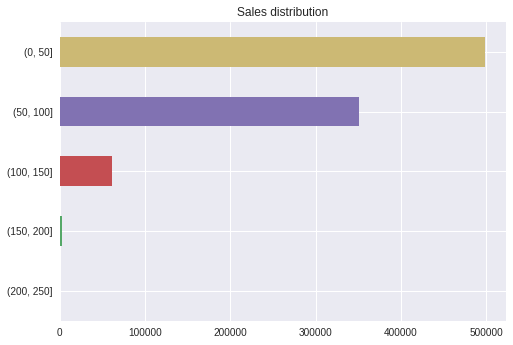

In [11]:
# Let us visualize the same
sales_count = pd.value_counts(sales_df.sales_bins)
sales_count.sort_values(ascending=True).plot(kind='barh', title='Sales distribution', );
#sns.countplot(sales_count)

In [0]:
for df in train, test:
  df['dayofmonth'] = df.date.dt.day
  df['dayofyear'] = df.date.dt.dayofyear
  df['dayofweek'] = df.date.dt.dayofweek
  df['month'] = df.date.dt.month
  df['year'] = df.date.dt.year
  df['weekofyear'] = df.date.dt.weekofyear
  df['is_month_start'] = (df.date.dt.is_month_start).astype(int)
  df['is_month_end'] = (df.date.dt.is_month_end).astype(int)
  df.head()

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 12 columns):
date              913000 non-null datetime64[ns]
store             913000 non-null int64
item              913000 non-null int64
sales             913000 non-null int64
dayofmonth        913000 non-null int64
dayofyear         913000 non-null int64
dayofweek         913000 non-null int64
month             913000 non-null int64
year              913000 non-null int64
weekofyear        913000 non-null int64
is_month_start    913000 non-null int64
is_month_end      913000 non-null int64
dtypes: datetime64[ns](1), int64(11)
memory usage: 83.6 MB


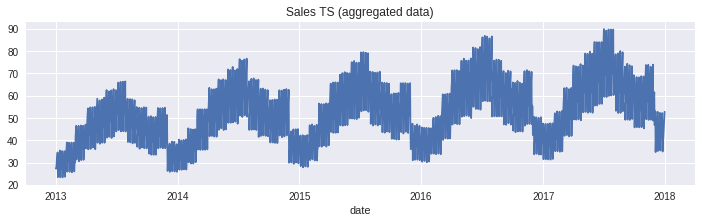

In [14]:
train.groupby('date').mean()['sales'].plot(figsize=(12,3), title='Sales TS (aggregated data)')

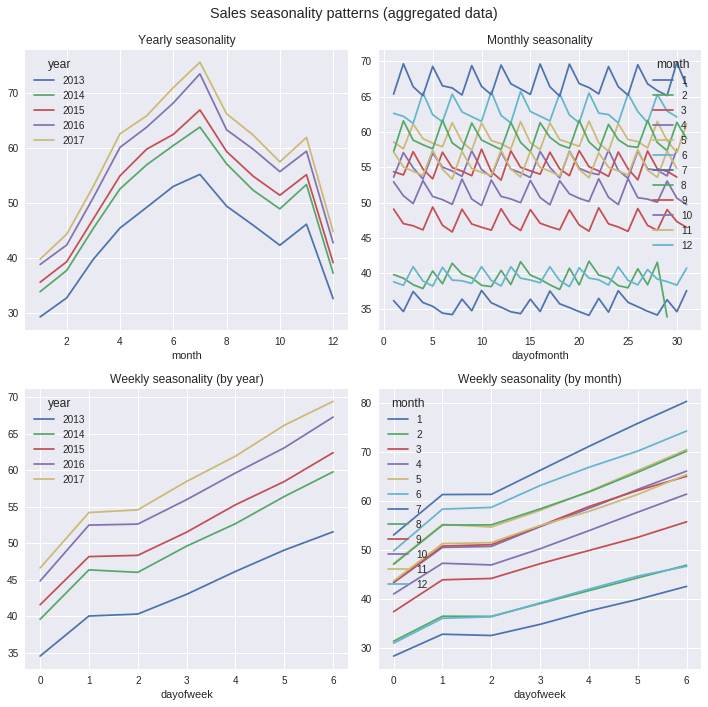

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(train, values='sales', columns='year', index='month').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(train, values='sales', columns='month', index='dayofmonth').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(train, values='sales', columns='year', index='dayofweek').plot(title="Weekly seasonality (by year)", ax=ax[1,0])
_ = pd.pivot_table(train, values='sales', columns='month', index='dayofweek').plot(title="Weekly seasonality (by month)", ax=ax[1,1])
fig.suptitle('Sales seasonality patterns (aggregated data)')
fig.tight_layout(rect=[0, 0, 1, 0.96])

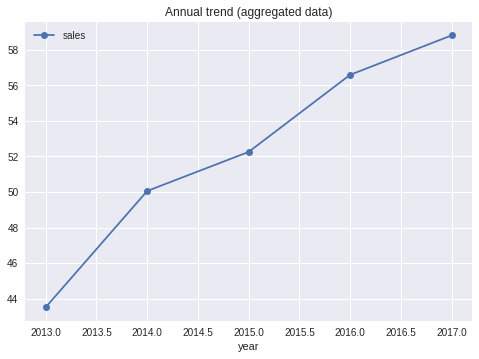

In [24]:
_ = pd.pivot_table(train, values='sales', index='year').plot(style='-o', title="Annual trend (aggregated data)")

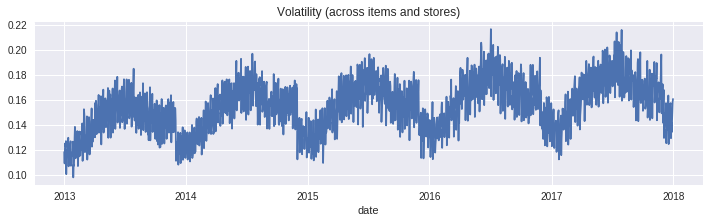

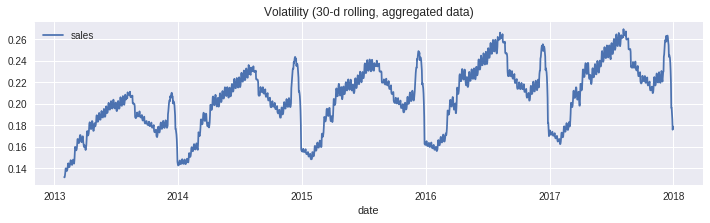

In [26]:
train_norm = train.copy()
train_norm['sales'] /= train.groupby(['item', 'store'])['sales'].transform('mean')
_ = train_norm.groupby(['date'])['sales'].std().plot(figsize=(12,3), title='Volatility (across items and stores)')
_ = (train_norm.groupby(['store', 'item'])[['date', 'sales']].rolling(30, on='date').std().groupby(['date']).mean()
     .plot(figsize=(12,3), title='Volatility (30-d rolling, aggregated data)'))

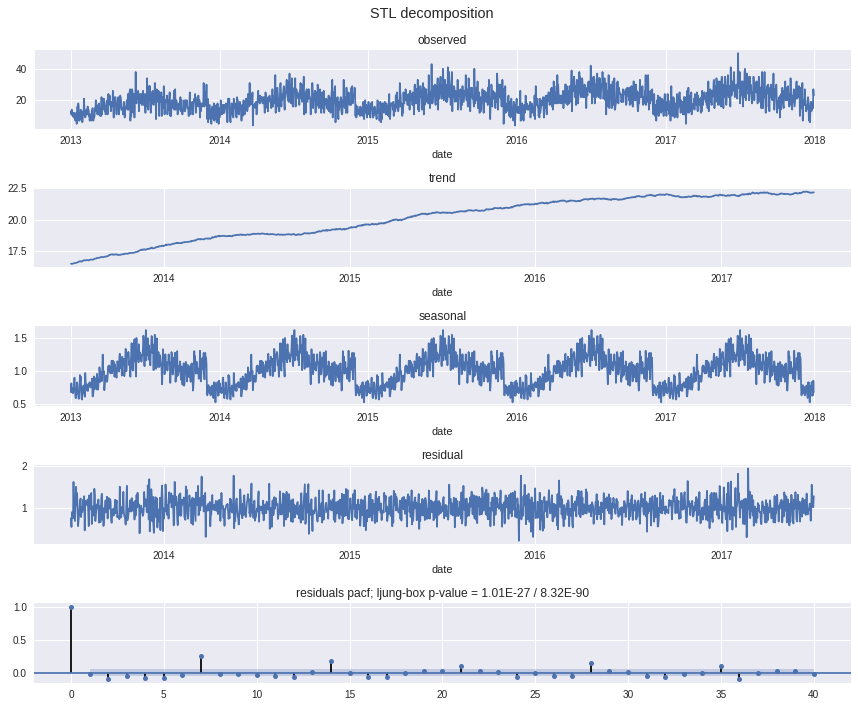

Output()

In [34]:
freq_season_mapping = {'None':None, 'Weekly': 7, 'Monthly':30, 'Yearly':365}

def update_stl_decompose(i_num, s_num, seasonality='Yearly', stl_style='additive'):
    ts = train.query('store == @s_num & item == @i_num').set_index('date')['sales']
    freq = freq_season_mapping[seasonality]
    
    fig, ax = plt.subplots(5, 1, figsize=(12,10))
    decomposition = sm.tsa.seasonal_decompose(ts, model=stl_style, freq=freq)
    _ = decomposition.observed.plot(ax=ax[0], title='observed')
    _ = decomposition.trend.plot(ax=ax[1], title='trend')
    _ = decomposition.seasonal.plot(ax=ax[2], title='seasonal')
    _ = decomposition.resid.plot(ax=ax[3], title='residual')
    res = decomposition.resid.values
    res = res[np.isfinite(res)]
#     adfuller_stat = statsmodels.tsa.stattools.adfuller(res)
    ljungbox_stat = statsmodels.stats.diagnostic.acorr_ljungbox(res)
    statsmodels.graphics.tsaplots.plot_pacf(res, ax=ax[4], lags=40, 
                                           title='residuals pacf; ljung-box p-value = {:.2E} / {:.2E}'.format(ljungbox_stat[1][6], 
                                                                                                              ljungbox_stat[1][30]))
    fig.suptitle('STL decomposition')
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    
s_slider = widgets.IntSlider(min=1, max=10, continuous_update=False, description='store', layout={'width': '2.1in', 'height': '1in'})
i_slider = widgets.IntSlider(min=1, max=50, continuous_update=False, description='item', layout={'width': '2.1in', 'height': '1in'})
season_drop = widgets.Dropdown(value='Yearly', options=['Weekly', 'Monthly', 'Yearly'], description='seasonality', layout={'width': '2.1in'})
stltype_drop = widgets.Dropdown(value='multiplicative', options=['additive', 'multiplicative'], description='STL type', layout={'width': '2.1in'})
ui = widgets.HBox([s_slider, i_slider, season_drop, stltype_drop], layout={'min_width': '6in', 'max_width': '6in'})
out = widgets.interactive_output(update_stl_decompose, {'s_num': s_slider, 'i_num': i_slider, 
                                                        'seasonality': season_drop, 'stl_style': stltype_drop})
display(ui, out)